In [75]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.integrate import trapezoid
import numpy as np
import awkward as ak
import pybaselines
from sklearn.preprocessing import normalize as norm

In [76]:
FILE_PATH = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0001.root" #Relative file path
file = uproot.open(FILE_PATH)
file["tree"].show()

FILE_PATH_2 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0002.root" #Relative file path
file2 = uproot.open(FILE_PATH_2)

FILE_PATH_3 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0003.root" #Relative file path
file3 = uproot.open(FILE_PATH_3)

FILE_PATH_4 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0004.root" #Relative file path
file4 = uproot.open(FILE_PATH_4)

FILE_PATH_5 = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0005.root" #Relative file path
file5 = uproot.open(FILE_PATH_5)

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


In [77]:
print(type(file["tree"]["base"].array()))
bl=file["tree"]["base"].array()
print(ak.num(bl))
#bl = bl[:-1]
print(np.unique(ak.num(bl)))
#l'ultimo array aveva una forma diversa, quindi l'ho tagliato altrimenti faceva casini

nch=file["tree"]["ch"].array()
print(nch)

<class 'awkward.highlevel.Array'>
[16, 16, 16, 16, 16, 16, 16, 16, 16, ..., 16, 16, 16, 16, 16, 16, 16, 16, 16]
[16]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], ..., [0, 1, ..., 15]]


In [78]:
baselines = np.array(file["tree"]["base"])[1:-1] 
charges = np.array(file["tree"]["charge"])[1:-1]
amp = np.array(file["tree"]["amp"])[1:-1]
lead_edge = np.array(file["tree"]["letime"])[1:-1]
t_edge = np.array(file["tree"]["tetime"])[1:-1]
channel= np.array(file["tree"]["ch"])[1:-1]
waveform = np.array(file["tree"]["pshape"])[1:-1]

#seconda batch

baselines2 = np.array(file2["tree"]["base"])[1:-1] 
charges2 = np.array(file2["tree"]["charge"])[1:-1]
amp2 = np.array(file2["tree"]["amp"])[1:-1]
lead_edge2 = np.array(file2["tree"]["letime"])[1:-1]
t_edge2 = np.array(file2["tree"]["tetime"])[1:-1]
channel2= np.array(file2["tree"]["ch"])[1:-1]
waveform2 = np.array(file2["tree"]["pshape"])[1:-1]

#terza batch

baselines3 = np.array(file3["tree"]["base"])[1:-1] 
charges3 = np.array(file3["tree"]["charge"])[1:-1]
amp3 = np.array(file3["tree"]["amp"])[1:-1]
lead_edge3 = np.array(file3["tree"]["letime"])[1:-1]
t_edge3 = np.array(file3["tree"]["tetime"])[1:-1]
channel3= np.array(file3["tree"]["ch"])[1:-1]
waveform3 = np.array(file3["tree"]["pshape"])[1:-1]

#quarta batch

baselines4 = np.array(file4["tree"]["base"])[1:-1] 
charges4 = np.array(file4["tree"]["charge"])[1:-1]
amp4 = np.array(file4["tree"]["amp"])[1:-1]
lead_edge4 = np.array(file4["tree"]["letime"])[1:-1]
t_edge4 = np.array(file4["tree"]["tetime"])[1:-1]
channel4= np.array(file4["tree"]["ch"])[1:-1]
waveform4 = np.array(file4["tree"]["pshape"])[1:-1]

#quinta batch

baselines5 = np.array(file5["tree"]["base"])[1:-1] 
charges5 = np.array(file5["tree"]["charge"])[1:-1]
amp5 = np.array(file5["tree"]["amp"])[1:-1]
lead_edge5 = np.array(file5["tree"]["letime"])[1:-1]
t_edge5 = np.array(file5["tree"]["tetime"])[1:-1]
channel5= np.array(file5["tree"]["ch"])[1:-1]
waveform5 = np.array(file5["tree"]["pshape"])[1:-1]

#concatenate arrays

baselines=np.concatenate((baselines, baselines2, baselines3, baselines4, baselines5))
charges = np.concatenate((charges, charges2, charges3, charges4, charges5))
amp = np.concatenate((amp, amp2, amp3, amp4, amp5))
lead_edge = np.concatenate((lead_edge, lead_edge2, lead_edge3, lead_edge4, lead_edge5))
t_edge = np.concatenate((t_edge, t_edge2, t_edge3, t_edge4, t_edge5))
channel = np.concatenate((channel, channel2, channel3, channel4, channel5))
waveform = np.concatenate((waveform, waveform2, waveform3, waveform4, waveform5))

In [79]:
print(amp.shape)
print(charges.shape)
print(len(amp))

(23856,)
(23856,)
23856


In [80]:
len(np.where(amp[0]>-1.2)[0])==16

True

In [81]:
print(channel)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 ...
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)                                                     ]


In [82]:

mask=[len(np.where(amp[i]>-1.2)[0])==16 for i in range(len(amp))]
print(mask)
baselines=baselines[mask]
charges=charges[mask]
amp=amp[mask]
lead_edge=lead_edge[mask]
t_edge=t_edge[mask]
channel=channel[mask]
waveform=waveform[mask]

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, False, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, False, True, False, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, False, True, True, True, True, Tru

In [83]:
print(len(amp))
Nev=len(amp)

18853


(18853,)
channel: 0 baseline: -0.000229 charge 0.898 lead_edge 344.295 trailing_edge 344.044
channel: 1 baseline: 0.000762 charge -2.78 lead_edge 231.141 trailing_edge 229.778
channel: 2 baseline: 0.000572 charge -3.003 lead_edge 402.412 trailing_edge 399.657
channel: 3 baseline: -7.6e-05 charge -0.303 lead_edge 165.419 trailing_edge 164.744
channel: 4 baseline: 0.00061 charge -4.004 lead_edge 463.754 trailing_edge 460.599
channel: 5 baseline: 0.000114 charge 0.177 lead_edge 465.609 trailing_edge 464.702
channel: 6 baseline: -0.000343 charge 1.813 lead_edge 341.86 trailing_edge 337.659
channel: 7 baseline: 0.000305 charge -2.316 lead_edge 440.94 trailing_edge 439.3
channel: 8 baseline: -0.000114 charge 3.237 lead_edge 299.689 trailing_edge 298.7
channel: 9 baseline: 0.0 charge -1.533 lead_edge 31.969 trailing_edge 30.544
channel: 10 baseline: -0.008082 charge -197.824 lead_edge 272.651 trailing_edge -0.003
channel: 11 baseline: 0.000229 charge -3.312 lead_edge 433.542 trailing_edge 429

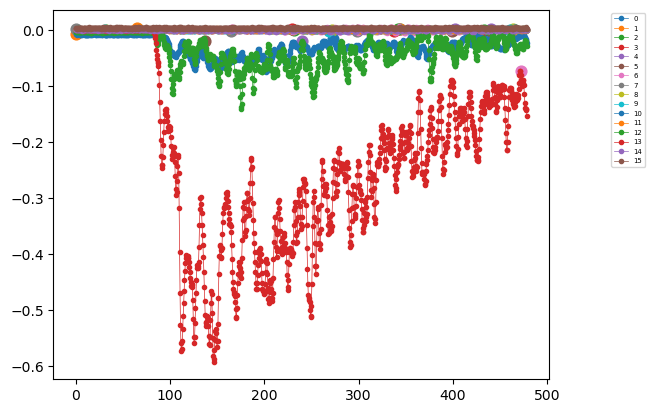

In [84]:
print(waveform.shape)
event=56
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#list=[1,2,7,12]
sampling=0.468
for channel in list:
    time=np.arange(1024)
    plt.plot(time*sampling, waveform[event][channel], '.-', label='{}'.format(channel), linewidth=0.5)
    print("channel:", channel, "baseline:",  baselines[event][channel],"charge", charges[event][channel], "lead_edge", lead_edge[event][channel], "trailing_edge", t_edge[event][channel] )
    t1=lead_edge[event][channel]
    t2=t_edge[event][channel]
    #print(t1,t2)
    plt.scatter( t1, waveform[event][channel][int(t1/sampling)],s=60   )
    plt.scatter( t2, waveform[event][channel][int(t2/sampling)],s=60  )
    #plt.xlim(400,600)
    #plt.ylim(-0.01, 0.1)

plt.legend(fontsize=5, loc='upper right', bbox_to_anchor=(1.2, 1))

In [85]:
###pulizia
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
true_charges=[]
true_amps=[]
true_channels=[]
true_waveforms=[]
true_ledge=[]
for ev in range(Nev):
    interesting_channels=np.where(charges[ev]<-50)[0] #canali che hanno visto qualcosa
    true_channels.append(interesting_channels.tolist())
    true_charges.append([charges[ev][ch] for ch in interesting_channels])
    true_amps.append([amp[ev][ch] for ch in interesting_channels])
    true_waveforms.append([waveform[ev][ch] for ch in interesting_channels])
    true_ledge.append([lead_edge[ev][ch] for ch in interesting_channels])


#print(true_channels)
#print(true_charges)





In [86]:
#eventi con 3 gamma
n_photons=[len(true_channels[i]) for i in range(Nev)]
n_photons=np.array(n_photons)
three_gamma_events=np.where(n_photons == 4)[0] #eventi con 4 fotoni totali (ortopositronio?)
print(three_gamma_events)
four_gamma_events=np.where(n_photons == 5)[0]
print(four_gamma_events)

[   16    23    29    60    86   149   158   176   211   213   214   225
   235   236   253   263   275   278   292   367   378   387   410   412
   434   442   449   518   575   594   598   620   627   705   738   769
   774   781   792   811   831   842   849   852   886   895   917   932
   963  1005  1035  1049  1055  1056  1058  1074  1086  1102  1118  1119
  1159  1164  1191  1201  1223  1242  1257  1295  1306  1313  1322  1327
  1349  1359  1384  1386  1398  1407  1417  1418  1439  1444  1497  1513
  1516  1536  1591  1594  1617  1621  1635  1668  1676  1686  1688  1693
  1729  1758  1770  1774  1799  1829  1848  1857  1862  1901  1903  1931
  1933  1958  2013  2018  2034  2093  2105  2124  2127  2139  2154  2232
  2276  2321  2324  2359  2404  2472  2478  2551  2554  2564  2569  2573
  2586  2592  2598  2611  2613  2629  2631  2655  2775  2818  2845  2846
  2891  2899  2978  2983  3000  3045  3076  3120  3140  3155  3164  3197
  3201  3244  3264  3267  3269  3279  3287  3340  3

In [87]:
#plot degli eventi di papabile ortopositronio

# Define the number of events to plot
"""num_events = len(three_gamma_events)

# Define the layout of subplots
num_cols = 2  # Number of columns of subplots
num_rows = (num_events + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create a new figure and axes for each subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 18))

# Flatten the axes array if it's multidimensional
axes = axes.flatten()

# Loop over each event in the event list
for i, event in enumerate(three_gamma_events):
    # Retrieve the list of channels for the current event
    list = true_channels[event]
    
    # Plot waveforms for each channel in the event
    for channel in list:
        time = np.arange(1024)  # Create an array of time samples
        axes[i].plot(time * sampling, waveform[event][channel], '.-', label='{}'.format(channel), linewidth=0.5)
        print("channel:", channel, "baseline:", baselines[event][channel], "charge", charges[event][channel], "lead_edge", lead_edge[event][channel], "trailing_edge", t_edge[event][channel])
        t1 = lead_edge[event][channel]
        t2 = t_edge[event][channel]
        #axes[i].scatter(t1, waveform[event][channel][int(t1 / sampling)], s=60)
        #axes[i].scatter(t2, waveform[event][channel][int(t2 / sampling)], s=60)
    
    # Add legend to the subplot
    axes[i].legend(fontsize=5, loc='upper right', bbox_to_anchor=(1.2, 1))
    axes[i].set_title(f'Event {event}')  # Set title for the subplot

# Adjust layout and display the plot
plt.tight_layout()
plt.show()"""



'num_events = len(three_gamma_events)\n\n# Define the layout of subplots\nnum_cols = 2  # Number of columns of subplots\nnum_rows = (num_events + num_cols - 1) // num_cols  # Calculate the number of rows needed\n\n# Create a new figure and axes for each subplot\nfig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 18))\n\n# Flatten the axes array if it\'s multidimensional\naxes = axes.flatten()\n\n# Loop over each event in the event list\nfor i, event in enumerate(three_gamma_events):\n    # Retrieve the list of channels for the current event\n    list = true_channels[event]\n    \n    # Plot waveforms for each channel in the event\n    for channel in list:\n        time = np.arange(1024)  # Create an array of time samples\n        axes[i].plot(time * sampling, waveform[event][channel], \'.-\', label=\'{}\'.format(channel), linewidth=0.5)\n        print("channel:", channel, "baseline:", baselines[event][channel], "charge", charges[event][channel], "lead_edge", lead_edge[event][cha

In [88]:
shift = 5

def times_from_waveforms(wf_narr, n_conv, threshold):

    lenghts = []
    wf_arr = []

    for evt in range(len(wf_narr)):
        for ch in range(len(wf_narr[evt])):
            wf_arr.append(wf_narr[evt][ch])
        lenghts.append(len(wf_narr[evt]))


    wf_arr = np.array(wf_arr)
    wf_arr = -norm(-np.array(wf_arr), norm = "max", axis = 1, copy = True, return_norm = False)

    ledges = np.zeros(wf_arr.shape[0])


    for evt in range(len(wf_arr)):

        bsl = wf_arr[evt][0:32].mean()
        wf_arr[evt] = np.convolve(wf_arr[evt], [1/n_conv] * n_conv, mode = "same") - bsl

        ledge= np.where(np.diff(np.sign(wf_arr[evt] - threshold)))[0][0]
        ledges[evt]=np.interp(threshold,  [wf_arr[evt][ledge-shift], wf_arr[evt][ledge+shift]], [ledge-shift, ledge+shift])

        #ledges[evt] = np.where(np.diff(np.sign(wf_arr[evt] - threshold)))[0][0]

        

        #plt.plot(range(1024), wf_arr[evt])
        #plt.plot([ledges[evt]] * 2, [ -1, 0])


    ledg_arr = []
    k = 0
    for i in range(len(lenghts)):
        tmp_list = []
        for j in range(lenghts[i]):
            tmp_list.append(ledges[k])
            k += 1
        ledg_arr.append(tmp_list)


    return ledg_arr



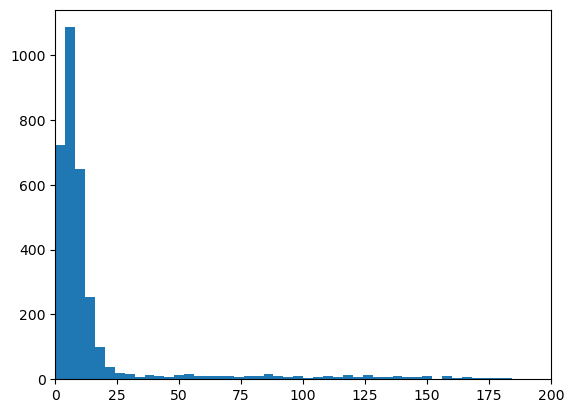

In [96]:

good_t_arr=[]
time_diff=[]

treshold=-0.020 #soglia fissa

arr_times_all=times_from_waveforms(true_waveforms, 15, treshold)
for ev in range(Nev):
    #trovo il leading edge del gamma da 1200
    index_1200=true_charges[ev].index(max(true_charges[ev]))
    ch_1200=true_channels[ev][index_1200] #trova il canale che ha visto la carica più alta
    t_arr=arr_times_all[ev] #calcolo tempi di arrivo dei segnali
    ev_is_good=[t_arr[i] >= t_arr[index_1200] and t_arr[index_1200]  for i in range(len(true_channels[ev]))]
    if(all(ev_is_good)):
        good_t_arr.append(t_arr)
        t_diff=[t_arr[i] - t_arr[index_1200] for i in range(len(t_arr))]
        t_diff.pop(index_1200)
        time_diff.append(t_diff)

        #print('Channels:', true_channels[ev])
        #print('ch 1200:', ch_1200)
        #print('T_arr:', t_arr)


#print(time_diff)
mean_time_diff=[np.mean(np.array(times)) for times in time_diff]
mean_time_diff=np.array(mean_time_diff)

bin_T, edgesT, _=plt.hist(mean_time_diff, bins=np.arange(np.min(mean_time_diff), np.max(mean_time_diff), step=4))

#pop away the first bin
bin_T=bin_T[2:30]
edgesT=edgesT[2:31]

Nbins = len(np.arange(np.min(mean_time_diff), np.max(mean_time_diff), step=4))
centersT = np.convolve(edgesT, [0.5, 0.5], "valid")
#plt.yscale('log')
plt.xlim(0, 200)

#evaluate errors

errT = np.sqrt(bin_T)

In [90]:
#proviamo a fittare

from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

In [91]:
exp1   = ExponentialModel(prefix='e1_')
exp2   = ExponentialModel(prefix='e2_')

model = exp1 + exp2

params = exp1.guess(bin_T, x=centersT)  
params.update(exp2.guess(bin_T, x=centersT)) 
params["e1_amplitude"].min = 0
params["e2_amplitude"].min = 0
params["e1_decay"].set(value=142)

result = model.fit(bin_T, params, x = centersT, weights = 1 / errT, nan_policy='omit')

print(result.fit_report())

[[Model]]
    (Model(exponential, prefix='e1_') + Model(exponential, prefix='e2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 138
    # data points      = 28
    # variables        = 4
    chi-square         = 24.1928951
    reduced chi-square = 1.00803730
    Akaike info crit   = 3.90792568
    Bayesian info crit = 9.23674372
    R-squared          = 0.99994513
[[Variables]]
    e1_amplitude:  11.9310239 +/- 2.51589959 (21.09%) (init = 62.92733)
    e1_decay:      247.142155 +/- 165.462457 (66.95%) (init = 142)
    e2_amplitude:  8313.42209 +/- 1110.75538 (13.36%) (init = 62.92733)
    e2_decay:      3.91481516 +/- 0.17142556 (4.38%) (init = 44.16685)
[[Correlations]] (unreported correlations are < 0.100)
    C(e2_amplitude, e2_decay)     = -0.9683
    C(e1_amplitude, e1_decay)     = -0.9400
    C(e1_amplitude, e2_decay)     = -0.4363
    C(e1_decay, e2_decay)         = +0.3849
    C(e1_amplitude, e2_amplitude) = +0.3698
    C(e1_decay, e2_amplitude)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


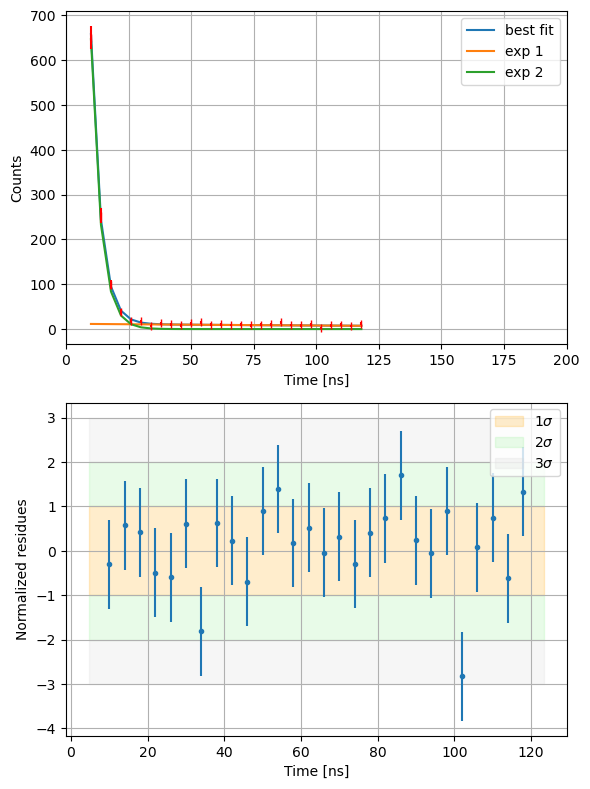

In [92]:
#plot del fit

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

#_ = ax1.hist(mean_time_diff, bins = Nbins, range = [0, 200], color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Time [ns]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersT, result.best_fit, label='best fit')
ax1.plot(centersT, comps['e1_'], label='exp 1')
ax1.plot(centersT, comps['e2_'], label='exp 2')


ax1.legend()
ax1.errorbar(centersT, bin_T, errT, color = "red", fmt='|')
ax1.set_xlim(0, 200)
ax1.grid()

residueT = bin_T - result.best_fit
norm_resT = residueT / errT

ax2.errorbar(centersT, norm_resT, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Time [ns]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)
#ax1.set_yscale('log')
ax2.legend()

fig.tight_layout()
plt.show()

[58.835495, 327.34048, 148.31, 132.91, 128.999, 157.87, 116.635, 76.125, 123.20999, 49.130493, 13.586487, 132.2495, 55.929996, 67.94501, 204.8315, 71.535, 85.57851, 301.3675, 190.9345, 293.892, 47.122993, 241.8175, 121.089005, 78.546, 238.177, 180.934, 259.4505, 24.425003, 144.5735, 138.0185, 231.06549, 88.23499, 280.38348, 139.953, 185.7345, 204.61, 286.92648, 97.681496, 15.266006, 285.901, 335.064, 135.132, 22.25299, 189.599, 255.1435, 7.8274994, 22.070503, 238.19852, 35.432007, 200.17249, 170.33199, 81.67549, 175.7815, 116.42549, 148.1115, 183.686, 98.35999, 76.62533, 224.07849, 132.4485, 103.494995, 111.743, 128.53549, 120.389496, 156.565, 250.51602, 212.926, 146.0285, 347.30847, 109.291, 89.184, 221.46301, 148.9965, 131.3725, 239.47649, 97.22951, 152.3465, 96.175, 25.925507, 110.5055, 36.763504, 184.643, 208.115, 76.722496, 90.59601, 144.5605, 249.3665, 83.718994, 75.785995, 211.49951, 198.116, 334.8355, 266.10464, 89.715, 204.4705, 152.448, 199.6465, 249.80249, 257.41898, 6.64849

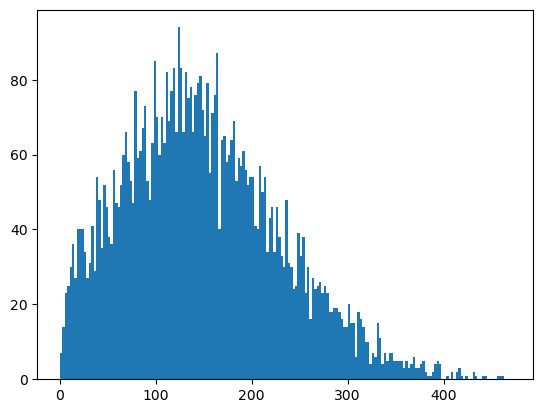

In [93]:
#distribuzione ottenuta con il leading edge

good_t_arr=[]
time_diff=[]

treshold=-0.020 #soglia fissa
for ev in range(Nev):
    #trovo il leading edge del gamma da 1200
    index_1200=true_charges[ev].index(max(true_charges[ev]))
    ch_1200=true_channels[ev][index_1200] #trova il canale che ha visto la carica più alta
    t_arr=[lead_edge[ev][ch] for ch in range(len(true_channels[ev]))] #calcolo tempi di arrivo dei segnali
    ev_is_good=[t_arr[i] >= t_arr[index_1200] and t_arr[index_1200]  for i in range(len(true_channels[ev]))]
    if(all(ev_is_good)):
        good_t_arr.append(t_arr)
        t_diff=[t_arr[i] - t_arr[index_1200] for i in range(len(t_arr))]
        t_diff.pop(index_1200)
        time_diff.append(t_diff)

        #print('Channels:', true_channels[ev])
        #print('ch 1200:', ch_1200)
        #print('T_arr:', t_arr)


#print(time_diff)
mean_time_diff=[np.mean(np.array(times)) for times in time_diff]
print(mean_time_diff)

_=plt.hist(mean_time_diff, bins=np.arange(np.min(mean_time_diff), np.max(mean_time_diff), step=2.5))


In [94]:
#per ogni evento 
"""def arrival_time(waveform, treshold):
    index=np.where(waveform <=treshold)[0][0]
    t_arr=index*sampling
    return t_arr


good_t_arr=[]
time_diff=[]

treshold=-0.020 #soglia fissa
for ev in range(Nev):
    #trovo il leading edge del gamma da 1200
    index_1200=true_charges[ev].index(max(true_charges[ev]))
    ch_1200=true_channels[ev][index_1200] #trova il canale che ha visto la carica più alta
    t_arr=[arrival_time(true_waveforms[ev][ch], treshold) for ch in range(len(true_channels[ev]))] #calcolo tempi di arrivo dei segnali
    ev_is_good=[t_arr[i] >= t_arr[index_1200] and t_arr[index_1200]  for i in range(len(true_channels[ev]))]
    if(all(ev_is_good)):
        good_t_arr.append(t_arr)
        t_diff=[t_arr[i] - t_arr[index_1200] for i in range(len(t_arr))]
        t_diff.pop(index_1200)
        time_diff.append(t_diff)

        #print('Channels:', true_channels[ev])
        #print('ch 1200:', ch_1200)
        #print('T_arr:', t_arr)


#print(time_diff)
mean_time_diff=[np.mean(np.array(times)) for times in time_diff]
print(mean_time_diff)

plt.hist(mean_time_diff, bins=20)"""




"def arrival_time(waveform, treshold):\n    index=np.where(waveform <=treshold)[0][0]\n    t_arr=index*sampling\n    return t_arr\n\n\ngood_t_arr=[]\ntime_diff=[]\n\ntreshold=-0.020 #soglia fissa\nfor ev in range(Nev):\n    #trovo il leading edge del gamma da 1200\n    index_1200=true_charges[ev].index(max(true_charges[ev]))\n    ch_1200=true_channels[ev][index_1200] #trova il canale che ha visto la carica più alta\n    t_arr=[arrival_time(true_waveforms[ev][ch], treshold) for ch in range(len(true_channels[ev]))] #calcolo tempi di arrivo dei segnali\n    ev_is_good=[t_arr[i] >= t_arr[index_1200] and t_arr[index_1200]  for i in range(len(true_channels[ev]))]\n    if(all(ev_is_good)):\n        good_t_arr.append(t_arr)\n        t_diff=[t_arr[i] - t_arr[index_1200] for i in range(len(t_arr))]\n        t_diff.pop(index_1200)\n        time_diff.append(t_diff)\n\n        #print('Channels:', true_channels[ev])\n        #print('ch 1200:', ch_1200)\n        #print('T_arr:', t_arr)\n\n\n#print(ti